<a href="https://colab.research.google.com/github/StoneMason495/cap-comp215/blob/main/215Project2ZMwithCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Daisy World: Testing the Gaia Hypothesis
###By: Zach Mason, COMP 215

In [112]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
from matplotlib import animation
import time
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

## 2D Animation Class:
For future simulations using Cellular Automata, I took the Animation 2D class that we have used throughout the term, so I take no credit for the creation of this class.

In [113]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [114]:
# Other borrowed elemtns 
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

##Daisy Class:
I created a simple data class to create each daisy, which only has its colour (inputted as a string), and the albedo, or amount of light reflected by a surface in decimal/fraction form (inputted as a float)
I chose the albedo values of 0.25 for black and 0.75 for white, as [this website](https://serc.carleton.edu/NAGTWorkshops/complexsystems/activities/daisyworld.html) utilized those values as well. The 0.75 value means that the white daisies will reflect 75% of the light shone upon them, where as the black daisies (with an albedo of 0.25) will absorb 75% of the light, and therefore the heat

In [135]:
B = lambda T: 1 - 0.003265*(22.5-T)**2 #The rate of growth for the daisies, T is equal to the temperature on the planet/ of the daisies (if T<5 or T>40, then B = 0)
@dataclass
class Daisy: #a dataclass, with only the colour of the daisy, and the albedo value (fractional value of light that a surface reflects)
  color : str
  albedo : float
  pop : float #Must be greater than 0, otherwise no growth can occur in a simulation
  
  def growth_rate(self, temp):
    growth_rate = self.pop * B(temp)
    return growth_rate if growth_rate > 0 else 0
  def death_rate(self, gamma=0.3):
    if self.pop > 0.01:
      return self.pop * gamma
    else:
      return 0
  def step(self):
    return 1

white = Daisy('white', 0.75, 0.001)
black = Daisy('black', 0.25, 0.001)

white.growth_rate(31), black.growth_rate(22.5)
white.death_rate(), black.death_rate()

(0, 0)

##Daisyworld Class:
In order to create a simulation, I created a second class, this time for the whole daisyworld, which takes inputs of a black and white daisy object, as well as leaving the option to lower the percentage of planet available, if one so desired

###Change of Luminosity Experiment:
In order to run the original daisyworld experiment, the luminosity must start at 0.5, and increase by 0.02 per timestep (0.5 + 0.02*(timestep))

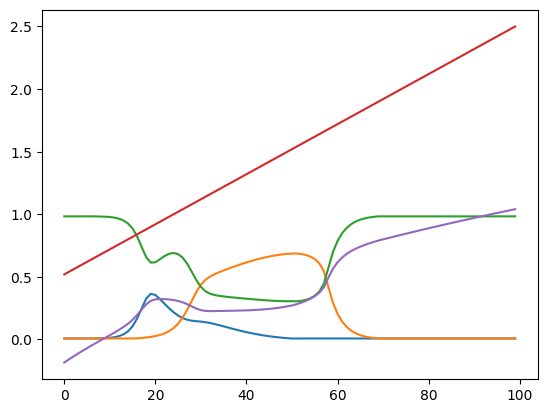

In [129]:
class Daisyworld:
  def __init__(self, b_daisy, w_daisy, p=1.0):
    '''initialize a Daisyworld object, in preparation for a simulation
    b_daisy : Daisy, choose the object you want to be the black daisies
    w_daisy : Daisy, choose the object you want to be the white daisies
    p : float, amount of fertile ground on planet, designed to be left at 1.0 (100%), but can be changed if desired
    luminosity : float, initial value of luminosity'''
    self.black = b_daisy #the black daisy used in the simulation, designed to be a daisy class object
    self.white = w_daisy #the white daisy used in the simulation, also designed to be a daisy class object
    self.p = p #the total planet percentage as a decimal, designed to be 1.0, but could in theory be lowered
    self.x = self.p - self.black.pop - self.white.pop #total planet remaining for expansion, utilized in calculations of growth
    self.luminosity = 0.5 #initial value of luminosity, which will then increase each step by (0.02*)
    self.sol_constant = 917
    self.stefboltz = 5.67*(10**-8)
    self.q = 0.2*(self.sol_constant/self.stefboltz)
    self.cycle_num = 0
  
  def dw_temp(self):
    '''calculates the temperature for the year on Daisyworld
    daisyworldtemp = ((solar_flux*(1-planetary_albedo)/stefboltz)^(0.25))-273'''
    temp = (((self.luminosity * self.sol_constant)*(1-self.dw_albedo())/self.stefboltz)**(0.25))-273
    return temp

  def dw_albedo(self):
    '''calculates the albedo (reflective quantity as a decimal/fraction) of the entire planet
    planetary_albedo = (white_daisies*WD_albedo)+(black_daisies*BD_albedo)+(X*bare_ground_albedo(=0.5))'''
    planet_albedo = (self.white.pop * self.white.albedo) + (self.black.pop * self.black.albedo) + (self.x*0.5)
    return planet_albedo

  def daisy_temp(self, daisy):
    '''Calculate the temperature of one of either black or white daisies in a daisyworld simulation
    D_temp = ((q*(planetary_albedo-D_albedo)+((daisyworld__temp+273)^4))^(0.25))-273'''
    d_temp = ((self.q*(self.dw_albedo()-daisy.albedo)+((self.dw_temp()+273)**4))**0.25)-273
    return d_temp

  def ground_temp(self):
    '''ground temperature = ((q*(planetary_albedo - bare_ground_albedo) + ((daisyworld__temp + 273)^4))^(0.25))-273'''
    g_temp = ((self.q*(self.dw_albedo-0.5) + ((self.dw_temp()+273)**4))**(0.25))-273
    return g_temp

  def step(self):
    '''Advances the simulation one timestep'''
    planet_temp = self.dw_temp()
    bd_temp = self.daisy_temp(self.black)
    wd_temp = self.daisy_temp(self.white)
    self.black.pop = self.black.pop + (self.black.growth_rate(bd_temp)*self.x)-self.black.death_rate() #calculates the population of black daisies
    self.white.pop = self.white.pop + (self.white.growth_rate(wd_temp)*self.x)-self.white.death_rate() #calculates the population of white daisies
    self.x = self.p - self.black.pop - self.white.pop
    planet_albedo = self.dw_albedo()
    self.cycle_num += 1
    self.luminosity = 0.5 + (0.02*self.cycle_num)


world = Daisyworld(black, white)
frames = 100
b_daisypop = []
w_daisypop = []
x_remaining = []
luminosity = []
world_temp = []
for i in range(frames):
  world.step()
  b_daisypop.append(world.black.pop)
  w_daisypop.append(world.white.pop)
  x_remaining.append(world.x)
  luminosity.append(world.luminosity)
  world_temp.append(world.dw_temp()/100)

plt.plot(range(frames), b_daisypop) #labelled as the blue line in the graph
plt.plot(range(frames), w_daisypop) #labelled as the orange line in the graph
plt.plot(range(frames), x_remaining) #labelled as the green line
plt.plot(range(frames), luminosity) #labelled as the red line
plt.plot(range(frames), world_temp) # Purple line, should not be read with the rest, as it has been scaled down to 'fit in'
plt.show()

As you can see, there is a range between steps 20 and 70 where the percentage of the planet covered by daisies increases, to be the majority, of the planet, keeping the temperature in check. Past step 70, the planet falls into chaos, the daisy population falls to zero, as the planet is too warm to supply life.

### Fixed Albedo Experiment:
In this experiment, the Albedo of the black and white daisies was set to 0.5, the same as the bare ground albedo.

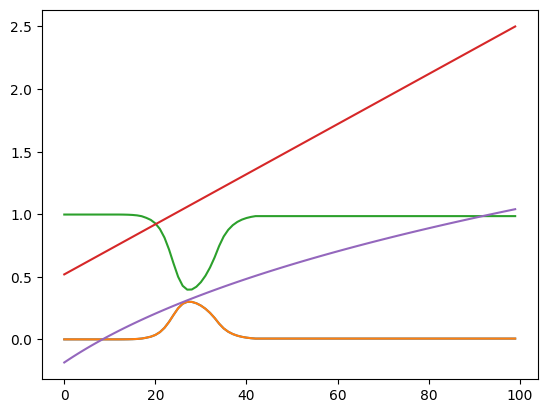

In [133]:
fixed_white = Daisy('white', 0.5, 0.001)
fixed_black = Daisy('black', 0.5, 0.001)

fixed_world = Daisyworld(fixed_black, fixed_white)
frames = 100
b_daisypop = []
w_daisypop = []
x_remaining = []
luminosity = []
world_temp = []
for i in range(frames):
  fixed_world.step()
  b_daisypop.append(fixed_world.black.pop)
  w_daisypop.append(fixed_world.white.pop)
  x_remaining.append(fixed_world.x)
  luminosity.append(fixed_world.luminosity)
  world_temp.append(fixed_world.dw_temp()/100)

plt.plot(range(frames), b_daisypop) #labelled as the blue line in the graph
plt.plot(range(frames), w_daisypop) #labelled as the orange line in the graph
plt.plot(range(frames), x_remaining) #labelled as the green line
plt.plot(range(frames), luminosity) #labelled as the red line
plt.plot(range(frames), world_temp) # Purple line, should not be read with the rest, as it has been scaled down to 'fit in'
plt.show()

As you can see, there is a very small window, around the 25-30 step mark, where the planet supports life. Outside of that window, the planet is totally barren, unable to supply life.

### Dire Event Occurence:
In this experiment, I set the luminosity to a static value of 1 (as opposed to the dynamic value of the last two experiments), and inputted a 'dire event', the almost total elimination 

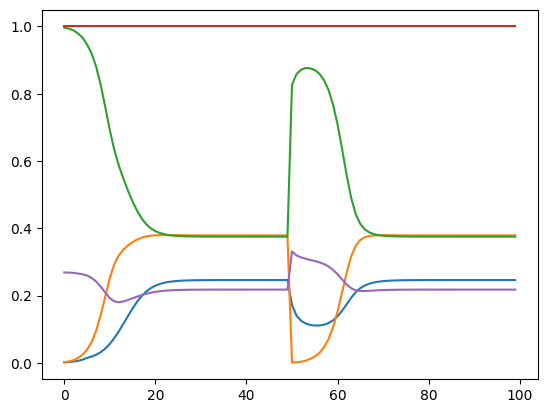

In [136]:
class DireDaisyworld:
  def __init__(self, b_daisy, w_daisy, p=1.0):
    '''initialize a Daisyworld object, in preparation for a simulation
    b_daisy : Daisy, choose the object you want to be the black daisies
    w_daisy : Daisy, choose the object you want to be the white daisies
    p : float, amount of fertile ground on planet, designed to be left at 1.0 (100%), but can be changed if desired
    luminosity : float, initial value of luminosity'''
    self.black = b_daisy #the black daisy used in the simulation, designed to be a daisy class object
    self.white = w_daisy #the white daisy used in the simulation, also designed to be a daisy class object
    self.p = p #the total planet percentage as a decimal, designed to be 1.0, but could in theory be lowered
    self.x = self.p - self.black.pop - self.white.pop #total planet remaining for expansion, utilized in calculations of growth
    self.luminosity = 1 #value of luminosity
    self.sol_constant = 917
    self.stefboltz = 5.67*(10**-8)
    self.q = 0.2*(self.sol_constant/self.stefboltz)
    self.cycle_num = 0
  
  def dw_temp(self):
    '''calculates the temperature for the year on Daisyworld
    daisyworldtemp = ((solar_flux*(1-planetary_albedo)/stefboltz)^(0.25))-273'''
    temp = (((self.luminosity * self.sol_constant)*(1-self.dw_albedo())/self.stefboltz)**(0.25))-273
    return temp

  def dw_albedo(self):
    '''calculates the albedo (reflective quantity as a decimal/fraction) of the entire planet
    planetary_albedo = (white_daisies*WD_albedo)+(black_daisies*BD_albedo)+(X*bare_ground_albedo(=0.5))'''
    planet_albedo = (self.white.pop * self.white.albedo) + (self.black.pop * self.black.albedo) + (self.x*0.5)
    return planet_albedo

  def daisy_temp(self, daisy):
    '''Calculate the temperature of one of either black or white daisies in a daisyworld simulation
    D_temp = ((q*(planetary_albedo-D_albedo)+((daisyworld__temp+273)^4))^(0.25))-273'''
    d_temp = ((self.q*(self.dw_albedo()-daisy.albedo)+((self.dw_temp()+273)**4))**0.25)-273
    return d_temp

  def ground_temp(self):
    '''ground temperature = ((q*(planetary_albedo - bare_ground_albedo) + ((daisyworld__temp + 273)^4))^(0.25))-273'''
    g_temp = ((self.q*(self.dw_albedo-0.5) + ((self.dw_temp()+273)**4))**(0.25))-273
    return g_temp

  def step(self):
    '''Advances the simulation one timestep'''
    planet_temp = self.dw_temp()
    bd_temp = self.daisy_temp(self.black)
    wd_temp = self.daisy_temp(self.white)
    self.black.pop = self.black.pop + (self.black.growth_rate(bd_temp)*self.x)-self.black.death_rate() #calculates the population of black daisies
    self.white.pop = self.white.pop + (self.white.growth_rate(wd_temp)*self.x)-self.white.death_rate() #calculates the population of white daisies
    self.x = self.p - self.black.pop - self.white.pop
    planet_albedo = self.dw_albedo()



white = Daisy('white', 0.75, 0.001)
black = Daisy('black', 0.25, 0.001)
world = DireDaisyworld(black, white)
b_daisypop = []
w_daisypop = []
x_remaining = []
luminosity = []
world_temp = []
for i in range(frames):
  world.luminosity = 1
  if i == frames//2:
    world.white.pop = 0.001
  world.step()
  b_daisypop.append(world.black.pop)
  w_daisypop.append(world.white.pop)
  x_remaining.append(world.x)
  luminosity.append(world.luminosity)
  world_temp.append(world.dw_temp()/100)

plt.plot(range(frames), b_daisypop) #labelled as the blue line in the graph
plt.plot(range(frames), w_daisypop) #labelled as the orange line in the graph
plt.plot(range(frames), x_remaining) #labelled as the green line
plt.plot(range(frames), luminosity) #labelled as the red line
plt.plot(range(frames), world_temp) # Purple line, should not be read with the rest, as it has been scaled down to 'fit in'
plt.show()

Little changes during this experiment, as once the 'dire event' occurs, it takes about 15 years for the planet to return back to its normal steady-state (this may be influenced by the fact that the program utilizes a perfectly static, pre-determined luminosity)

## Expanding the Daisyworld Class: Transitioning to Cellular Automata

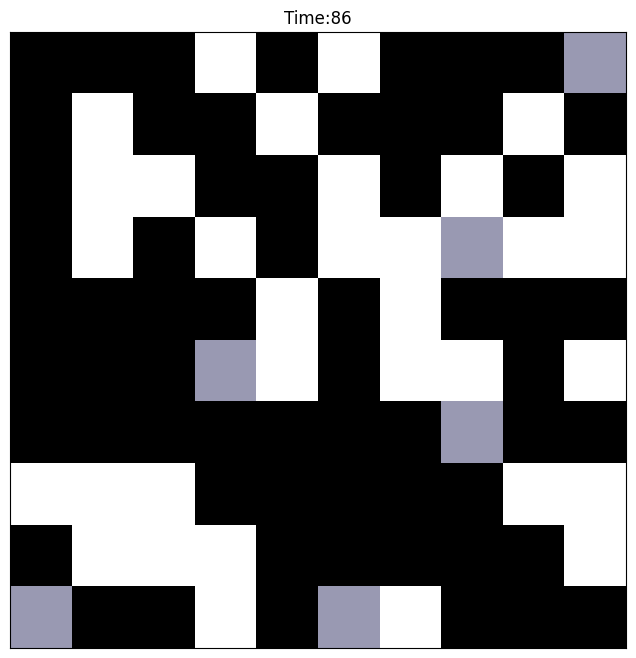

In [124]:
class Daisyworld_CA(Daisyworld):
  kernel = np.array([[0, 1, 0],
                    [1, 1, 1],
                    [0, 1, 0]])
  #Define three possible states for the Daisyworld simulation
  BARREN = 0
  BLACK = 1
  WHITE = 2

  #Creating a colour map for each colour
  cmap = [(0.6, 0.6, 0.7), (0, 0, 0), (1, 1, 1)]
  dw_colour_map = matplotlib.colors.ListedColormap(cmap)

  def __init__(self, b_daisy, w_daisy, rows, p=1.0):
    '''initialize a Daisyworld object, in preparation for a simulation
    b_daisy : Daisy, choose the object you want to be the black daisies
    w_daisy : Daisy, choose the object you want to be the white daisies
    p : float, amount of fertile ground on planet, designed to be left at 1.0 (100%), but can be changed if desired'''
    Daisyworld.__init__(self, b_daisy, w_daisy, p=p)
    self.rows = rows
    self.array = np.random.choice([self.BARREN, self.BLACK, self.WHITE], (rows, rows), p=[0.98, 0.01, 0.01])

  # def bd_growth(self):
  #   bd_temp = self.daisy_temp(self.black)
  #   bd_growth = (self.black.growth_rate(bd_temp)*self.x)-self.black.death_rate() #calculates the population of black daisies
  #   bd_growth = 0 if bd_growth < 0 else bd_growth
  #   return bd_growth

  # def wd_growth(self):
  #   wd_temp = self.daisy_temp(self.white)
  #   wd_growth = self.white.pop + (self.white.growth_rate(wd_temp)*self.x)-self.white.death_rate() #calculates the population growth of white daisies
  #   wd_growth = 0 if wd_growth < 0 else wd_growth
  #   return wd_growth

  def step(self):
    '''Advances the simulation one timestep'''
    planet_temp = self.dw_temp()
    bd_temp = self.daisy_temp(self.black)
    wd_temp = self.daisy_temp(self.white)
    self.black.pop = self.black.pop + (self.black.growth_rate(bd_temp)*self.x)-self.black.death_rate() #calculates the population of black daisies
    self.white.pop = self.white.pop + (self.white.growth_rate(wd_temp)*self.x)-self.white.death_rate() #calculates the population of white daisies
    self.x = self.p - self.black.pop - self.white.pop
    planet_albedo = self.dw_albedo()
    self.cycle_num += 1
    self.luminosity = 0.5 + (0.02*self.cycle_num)
    c = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
    barren = (self.array == self.BARREN) #unoccupied land, that will continue to be unoccupied in the next timestep
    black = (self.array == self.BLACK) #unoccupied land, will become a black daisy in the next timestep
    white = (self.array == self.WHITE) #unoccupied land, will become a white daisy in the next timestep
    self.array[barren] = np.random.choice([self.BARREN, self.BLACK, self.WHITE], self.array[barren].shape, p=[self.x, self.black.pop, self.white.pop])
    self.array[white] = np.random.choice([self.BARREN, self.WHITE], self.array[white].shape, p=[self.white.death_rate(), 1-self.white.death_rate()])
    self.array[black] = np.random.choice([self.BARREN, self.BLACK], self.array[black].shape, p=[self.black.death_rate(), 1-self.black.death_rate()])

  def draw(self, axes=None, step=''): #Needed for the Animation2D class, taken from previous labs
    """Draws the CA cells using the colour map so values are coloured intuitively."""
    axes = axes or plt.gca()
    title = f'Time:{step+1}'
    plot_2D_array(self.array, axes=axes, title=title,
                  cmap=self.dw_colour_map, vmin=0, vmax=len(self.dw_colour_map.colors))
    
CA_world = Daisyworld_CA(black, white, 10)
CA_world.array

Anim = Animation2D(CA_world, frames=100)
Anim.animate()

## Algorithm Analysis:


In [143]:
import timeit

In [144]:
%%timeit

white = Daisy('white', 0.75, 0.001)
black = Daisy('black', 0.25, 0.001)
timeit_world = Daisyworld(black, white)
timeit_world.step()

The slowest run took 5.96 times longer than the fastest. This could mean that an intermediate result is being cached.
27.5 µs ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
